1# Checkout Data analysis
##### The main objective is to find out if are there any anomaly behavior:

In [2]:
# Importing libraries
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Loading files
url1 = 'https://raw.githubusercontent.com/thais-menezes/monitoring/main/checkout_1.csv'
url2 = 'https://raw.githubusercontent.com/thais-menezes/monitoring/main/checkout_2.csv'

df1 = pd.read_csv(url1)
df2 = pd.read_csv(url2)
df = pd.concat([df1, df2], ignore_index=True)
df["time"] = df["time"].astype(str).str.extract(r"(\d{1,2})").astype(int)

## Summarizing the data.
pysqldf = lambda q: sqldf(q, globals())
try:
    query = """
    SELECT time, 
            SUM(today) as today,
            sum(yesterday) as yesterday,
            sum(same_day_last_week) as smlw,
            sum(avg_last_week) as avg_lw,
            sum(avg_last_month) as avg_lm
    FROM df
    GROUP BY time
    ORDER BY time
    """
    
    sql_result = pysqldf(query)
    df_sum = sql_result
    
except Exception as e:
    print(f"Could not create SQL-based plot: {str(e)}")
    
# Checking basic information about the data
print("\nDataFrame Info:")
print(df_sum.info())

# Optional: Get basic statistics of numerical columns
print("\nBasic Statistics:")
print(df_sum.describe())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       24 non-null     int64  
 1   today      24 non-null     int64  
 2   yesterday  24 non-null     int64  
 3   smlw       24 non-null     int64  
 4   avg_lw     24 non-null     float64
 5   avg_lm     24 non-null     float64
dtypes: float64(2), int64(4)
memory usage: 1.3 KB
None

Basic Statistics:
            time      today   yesterday       smlw     avg_lw     avg_lm
count  24.000000  24.000000   24.000000  24.000000  24.000000  24.000000
mean   11.500000  39.708333   43.708333  44.166667  27.419875  29.156250
std     7.071068  30.579162   35.961911  32.400573  20.117088  20.748115
min     0.000000   0.000000    0.000000   1.000000   0.560000   0.420000
25%     5.750000  10.500000    4.250000  13.750000   7.495000   8.422500
50%    11.500000  43.000000   53.000000  49.50000

#### Ploting the data

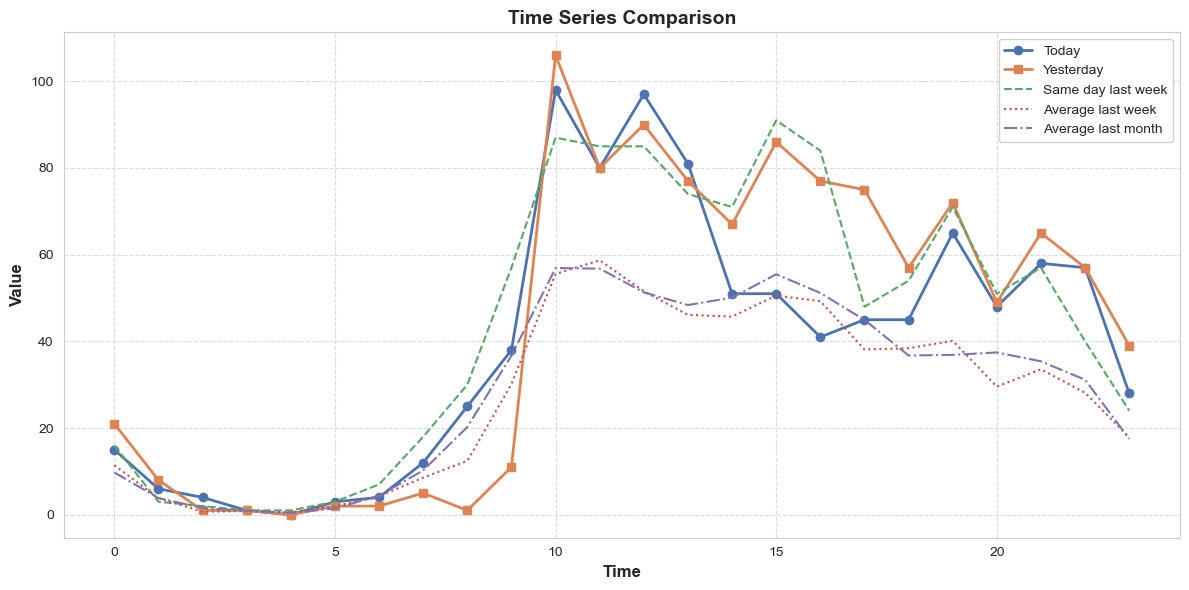

In [3]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Formating the chart
colors = sns.color_palette("deep")
plt.plot(df_sum['time'], sql_result['today'], marker='o', markersize=6,
linewidth=2, label='Today', color=colors[0])
plt.plot(df_sum['time'], sql_result['yesterday'], marker='s', markersize=6,
    linewidth=2, label='Yesterday', color=colors[1])
plt.plot(df_sum['time'], sql_result['smlw'], marker=None, linestyle='--',
    linewidth=1.5, label='Same day last week', color=colors[2])
plt.plot(df_sum['time'], sql_result['avg_lw'], marker=None, linestyle=':',
    linewidth=1.5, label='Average last week', color=colors[3])
plt.plot(df_sum['time'], sql_result['avg_lm'], marker=None, linestyle='-.',
    linewidth=1.5, label='Average last month', color=colors[4])

plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=12, fontweight='bold')
plt.title('Time Series Comparison', fontsize=14, fontweight='bold')

# Improving legend
plt.legend(loc='best', frameon=True, framealpha=0.9, fontsize=10)

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()


In [4]:
## Comparing today and yesterday to historical data to identify outliers, using Z-Score.
from scipy.stats import zscore

df_sum["zscore_today"] = zscore(df_sum["today"] - df_sum["avg_lw"])
anomalies_today = df_sum[df_sum["zscore_today"].abs() > 2]

print(anomalies_today) ## Anomalies identified in hours 10AM and 12PM today.
    

    time  today  yesterday  smlw  avg_lw  avg_lm  zscore_today
10    10     98        106    87   55.56   56.92      2.120860
12    12     97         90    85   51.57   51.31      2.331176


In [5]:
df_sum["zscore_yesterday"] = zscore(df_sum["yesterday"] - df_sum["avg_lw"])
anomalies_yesterday = df_sum[df_sum["zscore_yesterday"].abs() > 2]

print(anomalies_yesterday) ## Anomalies identified at 9am Yesterday.

   time  today  yesterday  smlw  avg_lw  avg_lm  zscore_today  \
9     9     38         11    57   30.14   36.71     -0.311498   

   zscore_yesterday  
9         -2.000426  


### Conclusions
###### Comparing today and yesterday data to historical data ( weekly and monthly average) i indetified anomalies at 10 AM and 12 AM today and at 9 AM yesterday).